# 2022-07-01 • g_EI

Playing with the between-group synaptic strengths and their effect on firing rate distributions.

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Sim

In [5]:
import PyPlot

In [6]:
using VoltoMapSim.Plot

In [7]:
function sim_and_plot(; params...)
    p = get_params(; params...)
    s = cached(sim, [p.sim])
    num_spikes = length.(s.spike_times)
    sum(num_spikes) > 0 || error("no spikes")
    spike_rates = num_spikes ./ p.sim.general.duration
    histplot_fr(spike_rates)
    rasterplot(s.spike_times, tlim=[0,10]seconds)
    return p, s, spike_rates
end;

## 4:1

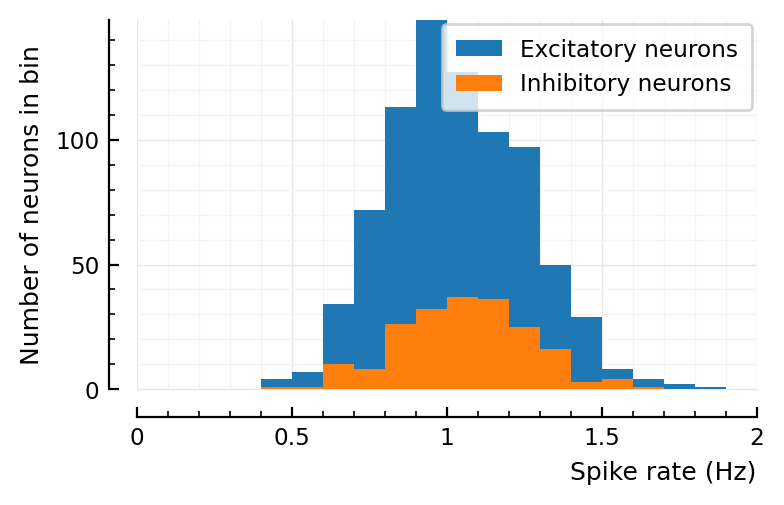

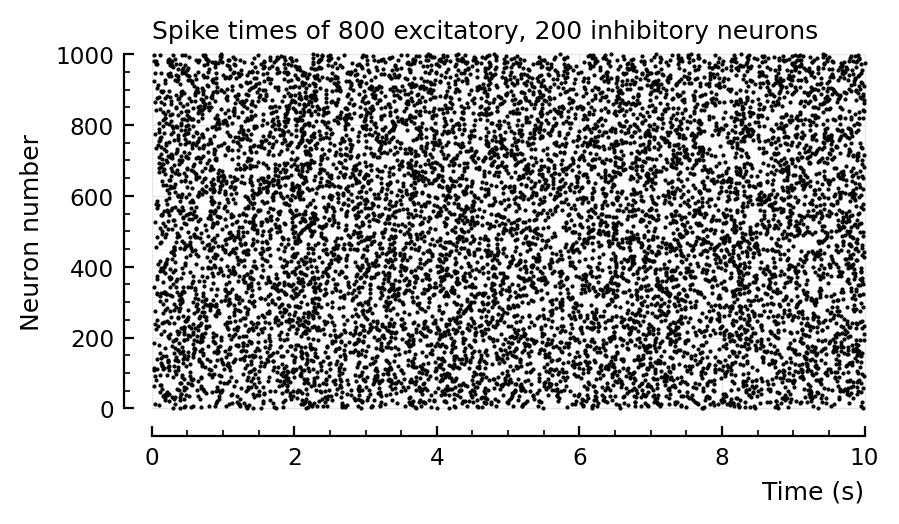

In [9]:
sim_and_plot(
    duration = 20seconds,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
);
# Default values

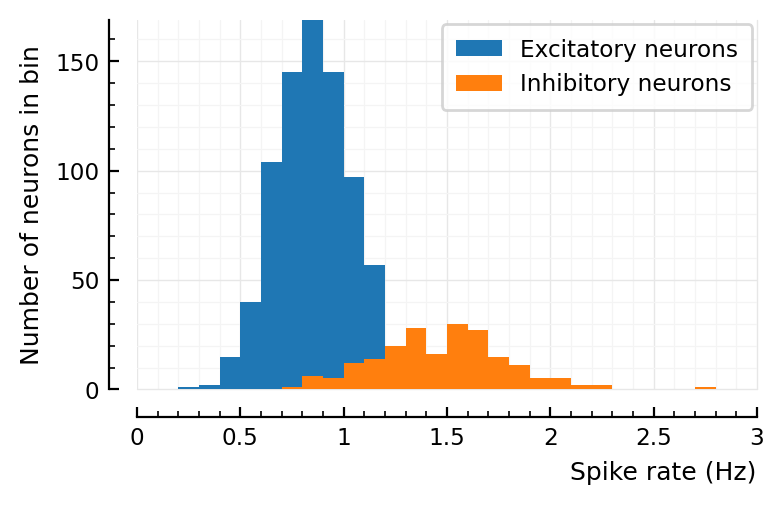

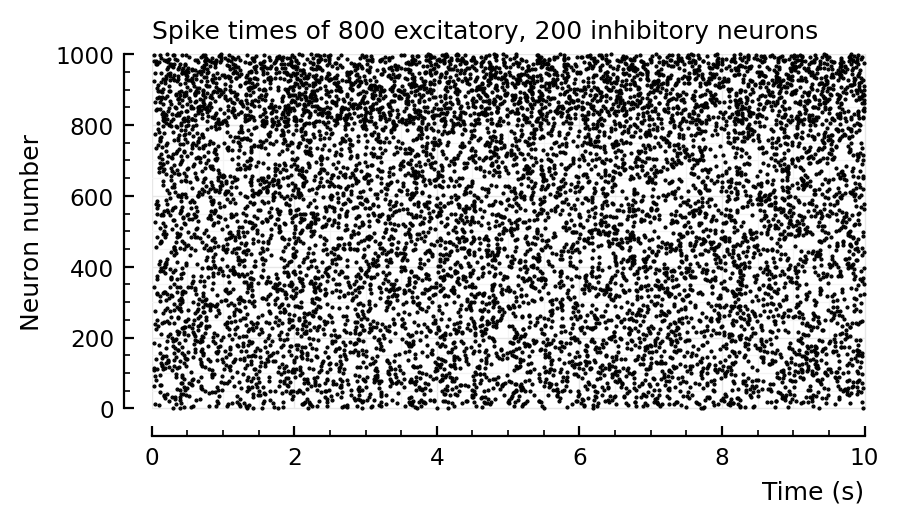

In [21]:
d = 2  # to lower firing rate
sim_and_plot(
    duration = 20seconds,
    g_EE = 1 / d,
    g_EI = 4 / d,
    g_IE = 1 / d,
    g_II = 4 / d,
);
# Previous, wrong values

Aggregated over E and I, you can indeed be fooled that the fr histogram is lognormal.

## Roxin2011

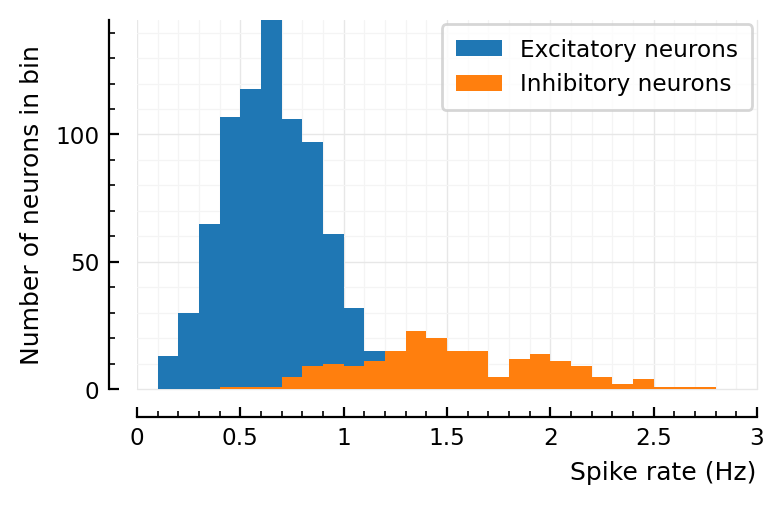

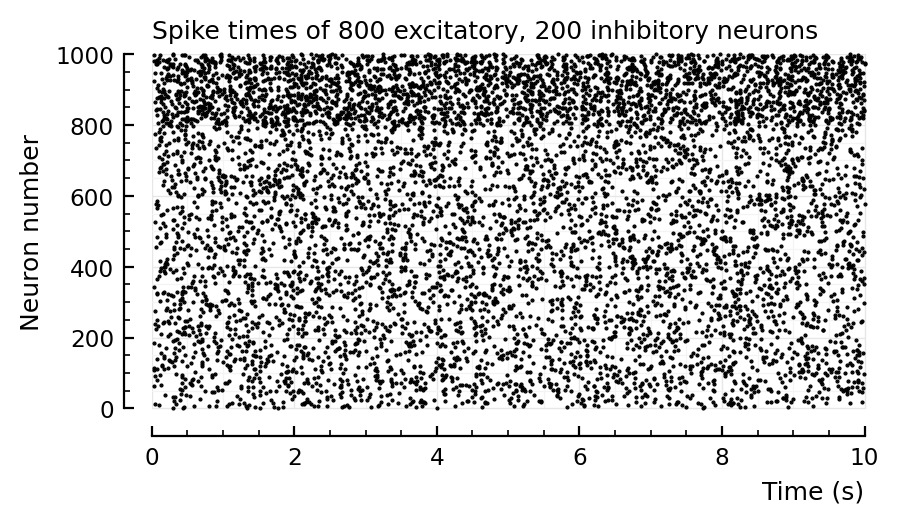

In [156]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 10seconds,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
);
# Roxin2011 values

Recreating plots from roxin.  
Here: aggregate spike rates of inh and exc, on log scale

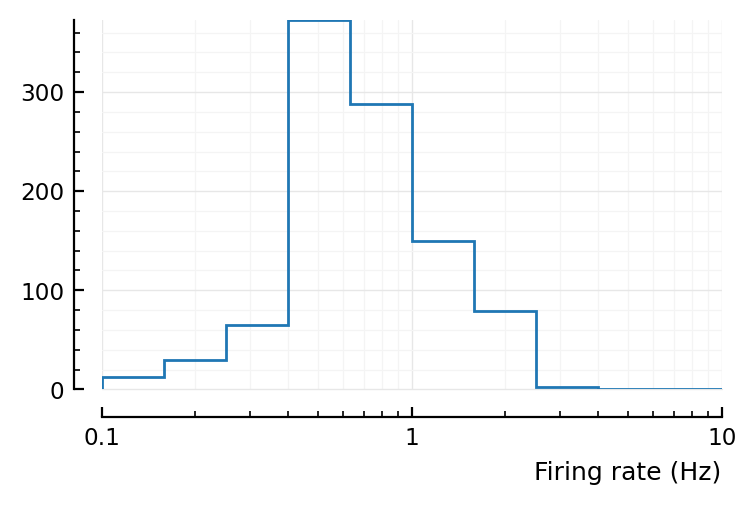

In [157]:
bins = exp10.(-1:0.2:1)
fig, ax = plt.subplots()
ax.hist(spike_rates; bins, histtype="step")
set(ax, xscale="log", xlabel="Firing rate (Hz)", xlim=(0.1,10));

Note that Roxin firing rates have much wider range: from 0.01 to 100

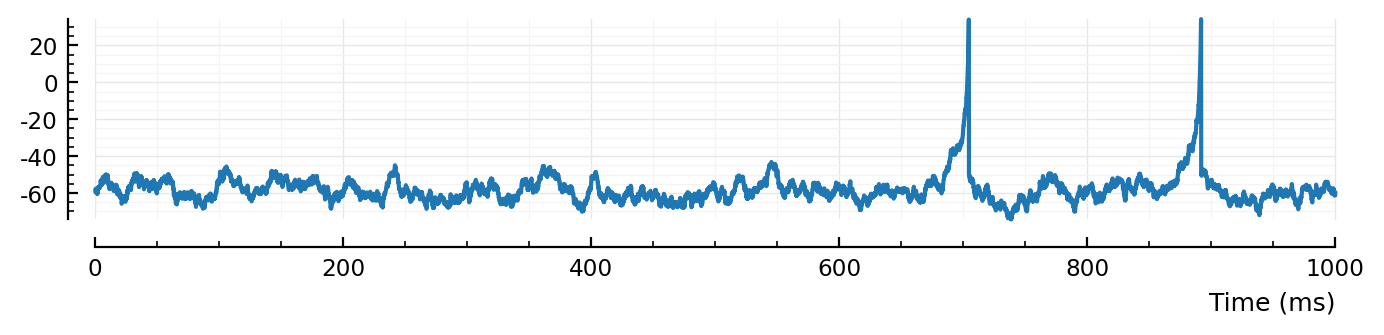

In [65]:
fig, ax = plt.subplots(figsize=(8,1.3))
plotsig(s.timesteps / ms, s.voltage_traces[1] / mV; ax, tlim=[0,1000], xlabel="Time (ms)");

## No lognormal weights

Roxin2011 finds that wider synaptic strength distribution gives __narrower__ firing rate distribution.
So let's do as they do in most plots, and give no variance at all to the synaptic weights.

Running simulation: 100%|███████████████████████████████| Time: 0:00:09
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\61e108c7773a503f.jld2` … done (0.2 s)


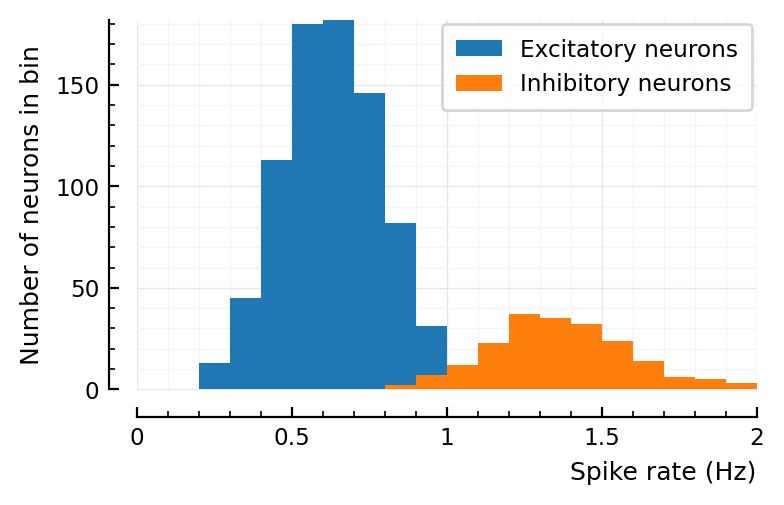

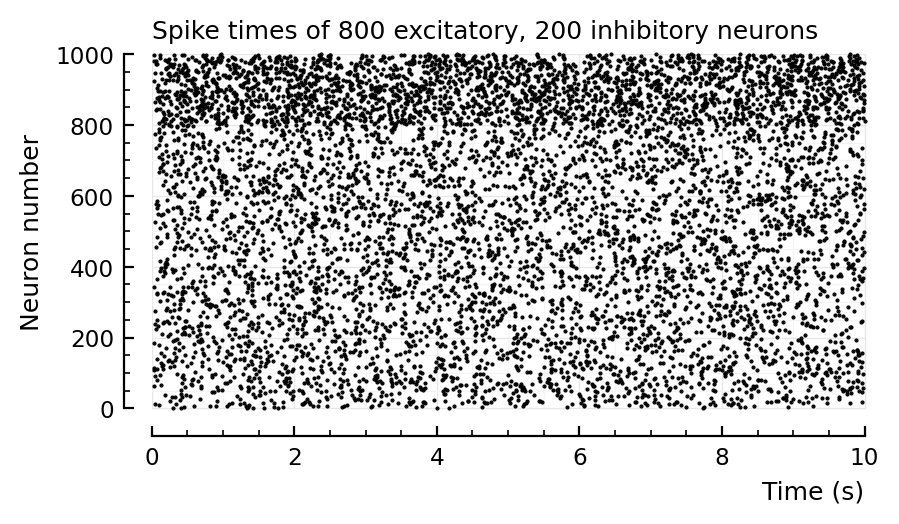

In [51]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 20seconds,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    syn_strengths = LogNormal_with_mean(20nS, 0)  # ← zero variance
);
# Roxin2011 values

Result: nope. Not wider

## Positive-mean input current

Positive as in: excitatory. (Previous defaults had zero-mean input current. But Roxin had positive mean; dV/dt ~ +I_ext in their eq. In our eq, dV/dt ~ –I_ext).

Also, they have lower p_conn than our default of 10%. (Result after changing this: not much difference)

In [97]:
1/√.1ms

3162.277660168379

Running simulation: 100%|███████████████████████████████| Time: 0:00:01
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\2d8e1e3dedc55948.jld2` … done (0.1 s)


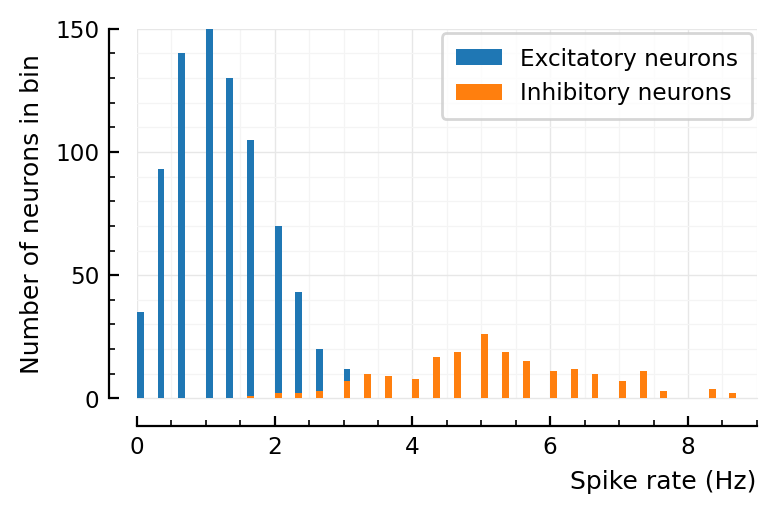

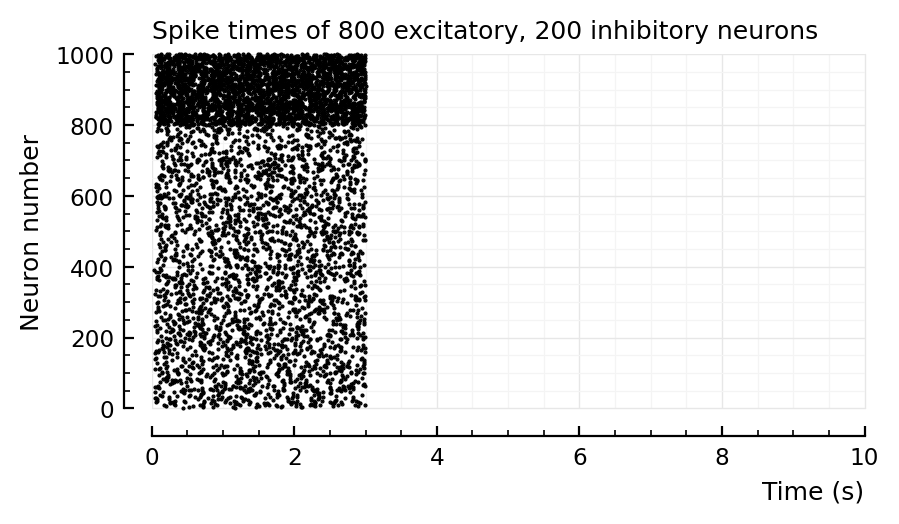

In [96]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 3seconds,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.42 * pA/√seconds, 4 * pA/√seconds),
);
# Roxin2011 values

The longer you simulate, the narrower both distributions seem to become.  

So I could see obtaining the approximate results of Roxin2011 figure 8:
- simulate for a short time  (they did not report their simulation time. But given that they have 2000x the number of neurons as us here, it can't have been very long).
- give the inhibitory neurons less external current (which is indeed what they did): their distribution will then overlap more with the excitatory one
- plot the firing rates in aggregate (not separate as I did here).

## Shape of normal on log scale

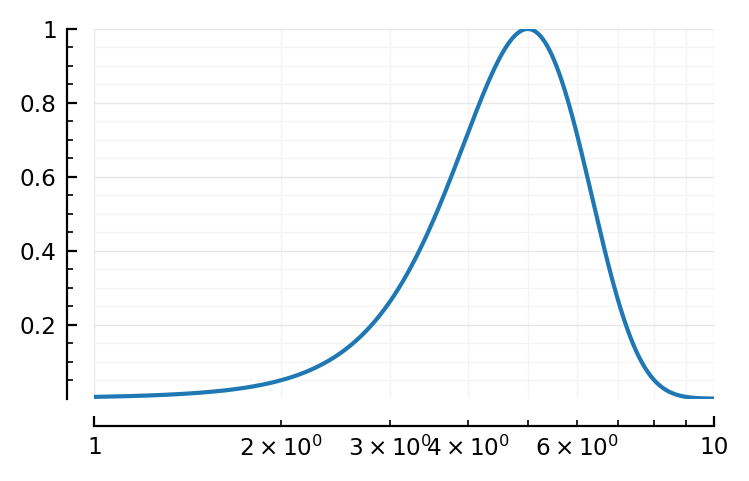

In [65]:
x = 1:0.01:10
y = @. exp(-(x-5)^2 / 3)
fig,ax = plt.subplots()
ax.plot(x,y);
set(ax, xscale="log");

Looks like the "very close to lognormal" plots in roxin.

## Truncated normal is 'heavy tailed'

Fig 5C of Roxin

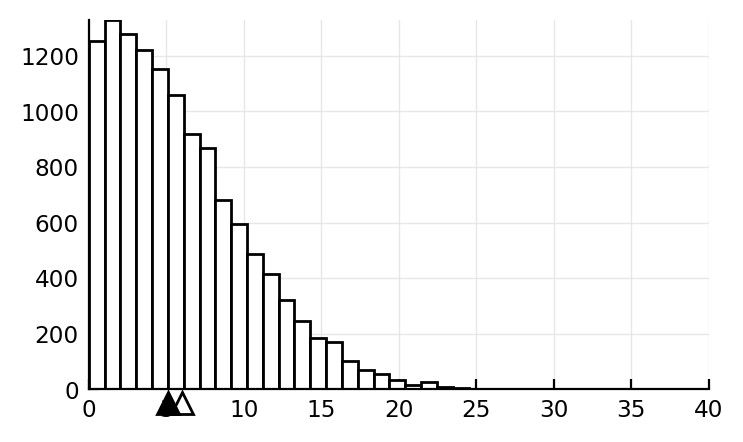

In [161]:
distr = TruncatedNormal(1Hz, 7Hz, 0Hz, Inf*Hz)  # mean, std, left bound, right bound
fr = rand(distr, 12500)
plt.hist(fr, bins=30, ec="k", fc="w")
plt.plot(mean(fr), -50, "w^", clip_on=false, mec="k", ms=8)
plt.plot(median(fr), -50, "k^", clip_on=false, mec="k", ms=8)
plt.ylim(bottom=0)
plt.xlim(0, 40);

In [162]:
median(fr), mean(fr)

(5.1193548485998175, 5.988978579872706)

tbf Roxin had a bit larger diff between these.

## Sum of two normals

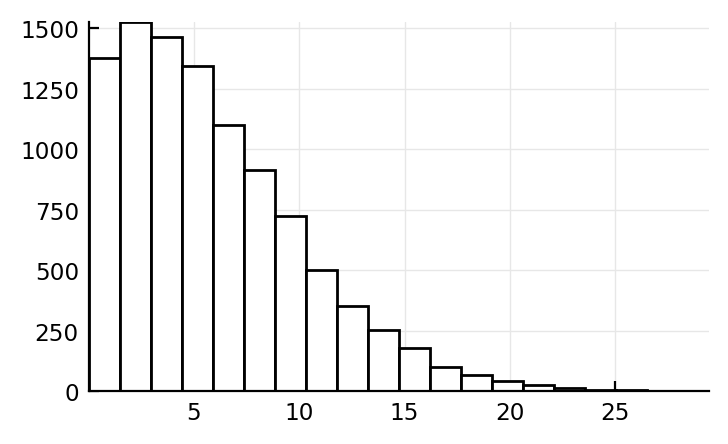

In [173]:
distr = truncated(MixtureModel(Normal, [(2Hz,5Hz), (8Hz,6Hz)], [0.8, 0.2]), lower=0Hz)
fr = rand(distr, 10_000)
plt.hist(fr, bins=20, ec="k", fc="w");

log scale:

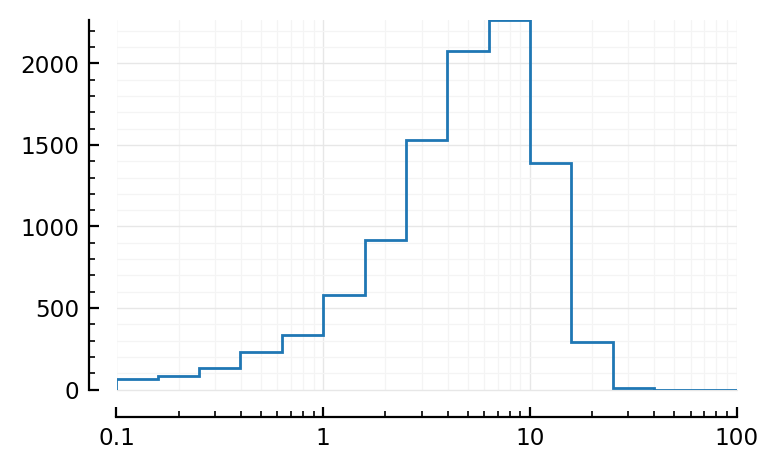

In [176]:
bins = exp10.(-1:0.2:3)
fig, ax = plt.subplots()
ax.hist(fr; bins, histtype="step")
set(ax, xscale="log", xlim=(0.1,100));

Looks very much like fig 8D.